In [1]:
import datetime as dt
import spiceypy as sp
import numpy as np
import pandas as pd

In [2]:
sp.furnsh('_kernels/lsk/naif0012.tls')
sp.furnsh('_kernels/spk/de440.bsp')
sp.furnsh('_kernels/pck/pck00010.tpc')

Last time we computed and visualised the movement of the Solar System Barycentre (SSB) with respect to the Sun. A 2-dimensional projection on the Ecliptic plane revealed an impressive behaviour of the SSB. The barycentre's position leaves the Sun on a regular basis, although the Sun contains more than 99% of the Solar System's mass. One can understand that this movement is caused by the other celestial objects like planets, the asteroids and even the dust. But what are the main contributors and can we visualize it?

For our analysis we will beed the same time interval and methods as shown last time. We will use additionally pandas.

Again we choose the time interval starting at the 1st January 2000 and add 10,000 days. We convert the <b>UTC time</b> strings to the <b>Ephemeris time (ET)</b> with the function <i><b>utc2et</b></i> and create a <b>numpy array</b> that contains all the ET time steps.

We want to compute the miscellaneous positions w.r.t. the centre of the Sun for a certain time interval

In [3]:
import datetime as dt
import spiceypy as sp
import numpy as np
import pandas as pd

# We want to compute the miscellaneous positions w.r.t. the centre
# of the Sun for a certain time interval
# First, we set an initial time in UTC.
INIT_TIME_UTC = dt.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# Add a number of days: you can play with this
DELTA_DAYS=10000
END_TIME_UTC = INIT_TIME_UTC + dt.timedelta(days=DELTA_DAYS)

# Convert the datetime objects now to strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = END_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')

# print the starting and end times
print('Init time in UTC: %s' % INIT_TIME_UTC_STR)
print('End time in UTC: %s\n' % END_TIME_UTC_STR)

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
INIT_TIME_ET = sp.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = sp.utc2et(END_TIME_UTC_STR)

# Create a numpy array that covers a time interval in delta = 1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [4]:
len(TIME_INTERVAL_ET)

10000

How should we proceed now with the analysis of the SSB's movement? Well first of all, we need to compute the trajectory of the barycentre with respect to the Sun. Last time we did this using a for-loop, now we will use pandas DataFrame to store all the necessary results in one place.

SPICE returns the spatial information in km. Again we want to scale it with Syn's radius. We extract this information from the kernel with the function <b><u><i>bodvcd</i></u></b>.

Using <b>km</b> is not intuitive. <b>AU</b> would scale it too severely. Since we compute the Solar System Barycentre (SSB) w.r.t. the Sun and since we expect it to be close to the Sun, we scale the <u>x,y,z component w.r.t. the radius of the Sun</u>. We extract the Sun radii (x,y,z components of the Sun ellipsoid) and use the x component.

In [5]:
# Using km is not intuitive. AU would scale it too severely. 
# Since we compute the Solar System Barycentre (SSB) w.r.t. the 
# Sun and since we expect it to be close to the Sun, we scale 
# the x,y,z component w.r.t. the radius of the Sun. 
# We extract the Sun radii (x,y,z components of the Sun ellipsoid)
# and use the x component.

_, RADII_SUN = sp.bodvcd(bodyid=10, item='RADII', maxn=3)
RADIUS_SUN = RADII_SUN[0]



The results will be stored in a SOLAR_SYSTEM_DF.

In [6]:
# All our parameters, positions etc. shall be stored in a df.
SOLAR_SYSTEM_DF = pd.DataFrame()

# Set the column ET that stores all ETs
SOLAR_SYSTEM_DF.loc[:, 'ET'] = TIME_INTERVAL_ET

# The column UTC transforms all ETs back to UTC format. 
# The function sp.et2datetime is not official part of the SPICE
# There it is et2utc. However the function returns immediately a datetime
# object.

SOLAR_SYSTEM_DF.loc[:, 'UTC'] = SOLAR_SYSTEM_DF['ET'].apply(lambda x: sp.et2datetime(et=x).date())

In [7]:
SOLAR_SYSTEM_DF.head()

,ET,UTC
0,-43135.816087,2000-01-01
1,43272.825277,2000-01-02
2,129681.466641,2000-01-03
3,216090.108006,2000-01-04
4,302498.749370,2000-01-05


We add and compute 3 new columns. First POS_SSB_WRT_SUN is computed that contains the position vector of the SSB as seen from the Sun. For this computation we need the ET column and apply row-wise (using <b>.apply()</b>) the SPICE function <b><i><u>spkgps</u></i></b> via a lambda function. <b><i><u>spkgps</u></i></b> requires the target NAIF ID (targ), the ET (et), the reference frame (ref: here it is the Ecliptic reference frame <b>ECLIPJ2000</b>) and the observer's NAIF ID (obs). The ID for the <u>SSB and Sun is 0 and 10</u> respectively.

The computed position vectors are then scaled with the Sun's radius. We apply the row-wise lambda function that divides the arrays by the radius.

Finally the distance between the Sun and the SSB is computed, using the SPICE function <b><i><u>vnorm</u></i></b>. The function compues the length (so-called norm) of a vector and is identical to the numpy function <i>numpy.linalg.norm()</i>.

In [8]:
# Here the position of the SSB, as seen fromthe Sun is computed.
# Since sp.spkgps returns the position and the corresponding light time,
# we add the index [0] to obtain only the position array.

SOLAR_SYSTEM_DF.loc[:, 'POS_SSB_WRT_SUN'] = SOLAR_SYSTEM_DF['ET'].apply(lambda x: sp.spkgps(targ=0, et=x, ref='ECLIPJ2000', obs=10)[0])

# Finally the distance between the Sun and the SSB is computed
SOLAR_SYSTEM_DF.loc[:, 'POS_SSB_WRT_SUN_SCALED'] = SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].apply(lambda x: x / RADIUS_SUN)

# Finally the distance between the Sun and the SSB is computed. The length
# (norm) of the vector needs to be determined with the SPICE function
# vnorm(). numpy provides an identical function in numpy.linalg.norm()
SOLAR_SYSTEM_DF.loc[:, 'SSB_WRT_SUN_SCALED_DIST'] = SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN_SCALED'].apply(lambda x: sp.vnorm(x))

In [9]:
SOLAR_SYSTEM_DF.head()

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST
0,-43135.816087,2000-01-01,"[1068108.3542452406, 417721.91444219963, -3086...","[1.5346384400075295, 0.6001751644284478, -0.04...",1.648421
1,43272.825277,2000-01-02,"[1067303.666657607, 418830.0833823817, -30854....","[1.53348227968047, 0.6017673611815829, -0.0443...",1.647925
2,129681.466641,2000-01-03,"[1066497.7243846857, 419937.0428411623, -30840...","[1.5323243166446634, 0.6033578201740838, -0.04...",1.647429
3,216090.108006,2000-01-04,"[1065690.5295479323, 421042.79723565804, -3082...","[1.5311645539481786, 0.6049465477523822, -0.04...",1.646933
4,302498.749370,2000-01-05,"[1064882.0840889374, 422147.350974351, -30812....","[1.5300029943806572, 0.6065335502505043, -0.04...",1.646436


Whether it is data science, space science, astronomy or any other scientific field, visualizing and describing data is the first step of a proper analysis.

So let’s visualise the distance between the SSB and the Sun as a function of time. For this purpose we use the module matplotlib, as introduced last time. We use the data of the column SSB_WRT_SUN_SCALED_DIST and plot it against the UTC date-time.

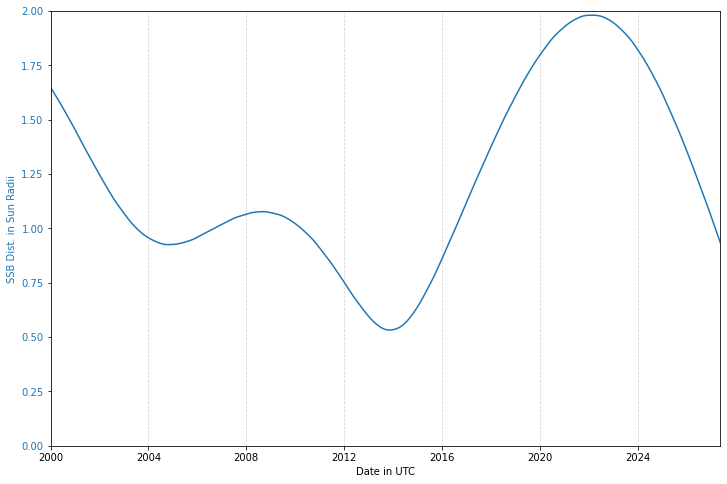

In [10]:
import matplotlib.pyplot as plt

# set a figure
FIG, AX = plt.subplots(figsize=(12,8))

# Plot the distance between the Sun and the SSB
AX.plot(SOLAR_SYSTEM_DF['UTC'], SOLAR_SYSTEM_DF['SSB_WRT_SUN_SCALED_DIST'], color = 'tab:blue')

# Set a label for the x and y axis and color the y ticks accordingly
AX.set_xlabel('Date in UTC')
AX.set_ylabel('SSB Dist. in Sun Radii', color='tab:blue')
AX.tick_params(axis='y', labelcolor='tab:blue')

# Set the limits for x andy axis
AX.set_xlim(min(SOLAR_SYSTEM_DF['UTC']), max(SOLAR_SYSTEM_DF['UTC']))
AX.set_ylim(0,2)

# Set a grid
AX.grid(axis='x', linestyle='dashed', alpha=0.5)

# Saving the figure in high quality
plt.savefig('SSB2SUN_DISTANCE.png', dpi=300)

Distance between the Solar System Barycentre (SSB) vs. the UTC date-time. The distance is given in Solar Radii. <b>1 Solar Radii corresponds to 696,000 km</b>.

Let use understand the plot. We see the distance between the SSB and the Sun vs. the date-time given in UTC. The distance-axis is scaled between 0 and 2 Solar Radii and the time axis starts at the year 2000 and ends right before 2028. We see that the <b>distance varies with time</b>, however, the <b>variation</b> appears to be <b>modulated</b> (different amplitudes and also frequencies). The distance between two <b>local maxima</b>, around the year <b>2009 and 2022 is approximately a decade</b>.

What do these slow temporal changes mean? The SSB's position w.r.t. the Sun can be theoritically computed by the sum of all gravity forces (planets, asteroids, dust, etc.). The inner planets (Mercury to Mars) have an orbital period between 90 days and almost 2 years. If the masses of these planets would be significant for the computation of SSB, we would see a lot of spiles and fast changing variations, but we do not.

Compared to the inner planets, the outer gas giants (Jupiter, Saturn, Uranus and Neptune) have a larger mass and a larget orbital period. Jupiter revolves around the Sun in about 12 years, Saturn needs almost 30 years. Although they are further away (Jupiter around 5 AU and Saturn around 9.5 AU) it appears they influence the SSB's position severely.

<b>Can we see this effect in data?</b>

## The Phase Angle
Say on <b>29th April 2020</b>, we see the <b>Moon</b> in its <b>waxing phase</b>. With every second the illuminated areas as seen from the Earth increases. In a few days the Moon is <b>fully illuminated</b> and its <b>waning phase begins</b>. During its revolutions around us, the Moon appears in different so called phase angles w.r.t. the Sun. Consider this:

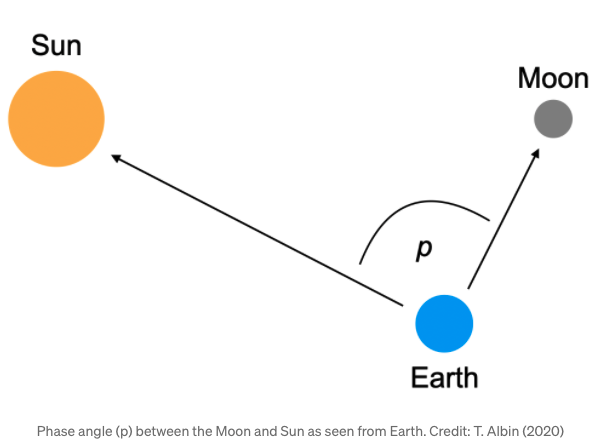

The <b>phase angle</b> is the angle between the <b>directional vectors</b> of the <b>Sun</b> and the <b>Moon</b> as seen from the <b>Earth</b>. Generally speaking; the phase angle is the angle that is <b>enclosed by 2 directional vector</b> as seen from an observer. Thus the phase angle can be computed between any celestial objects and is defined between <b>0</b> and <b>180 degrees</b>.

How is this related to SSB analysis? As mentioned before, we have the theory that the <b>gas giants' gravitational pull</b> is the most relavent factor of the SSB's movement. A large distance between the SSB and the Sun's centre could mean that the <b>outer planets 'line up'</b> to create a <b>stronger gravitational pull</b> from the same direction.

To check this phase angle dependency, we add new columns to our data-frame that contains the angles for all gas giants. Forst, we set up a dictionary that contains an abbreviated name for the planets (barycentres) with the corresponding planet's NAIF ID codes.

A for loop iterates through the dictionary and creates dunamically 2 new columns for each planet (the substring %s is replaced by the plante's abbreviation):

1. POS_%s_WRT_SUN: Position vector of the planet as seen from the Sun. For tis computation we use again the .apply functionality on the ETs and use the SPICE function <b><i><u>spkgps</u></i></b> for this purpose.
2. PHASE_ANGLE_SUN_%s2SSB: Phase angle between the planet and the SSB as seen from the Sun. .apply is applied on axis=1, since we need 2 columns for this computation, namely POS_%s_WRT_SUN and the SSB's direction vector from the Sun POS_SSB_WRT_SUN. The angle between these 2 vectors is calculated with the SPICE function <b><i><u>vsep</u></i></b>. The result is in rad, thus the numpy function <b>numpy.degrees()</b> is used to convert it to degrees.

In [11]:
print(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN_SCALED'].loc[1])

[ 1.53348228  0.60176736 -0.04433153]


In [12]:
# Additionally we want to compute the position vector of all outer
# gas giants. We define a dictionary with a planet's barycentre abbreviation
# and corresponding NAIF ID code

NAIF_ID_DICT = {
    'JUP': 5,
    'SAT': 6,
    'URA': 7,
    'NEP': 8
}

# Iterate through the dictionary and compute the position vector
# for each planet as seen from the Sun. Further, compute the phase
# angle between the SSB and the lanet as seen from teh Sun

for planets_name_key in NAIF_ID_DICT:
    
    # define the pandas datagrame column for each planet (position
    # and phase angle). Each '%s' substring is replaced with the planets
    # name as indicated after the %.
    
    planet_pos_col = 'POS_{}_WRT_SUN'.format(planets_name_key)
    planet_angle_col = 'PHASE_ANGLE_SUN_{}2SSB'.format(planets_name_key)
    
    # Get the corresponding NAIF ID of the planet's barycentre
    planet_id = NAIF_ID_DICT[planets_name_key]
    
    # Compute the planet's position as seen from the Sun.
    SOLAR_SYSTEM_DF.loc[:, planet_pos_col] = SOLAR_SYSTEM_DF['ET'].apply(lambda x: sp.spkgps(targ = planet_id, et=x, ref='ECLIPJ2000', obs=10)[0])
    
    # Compute the phase angle between the SSB and the planet
    #as seen from the Sun. Since we apply a lambda function on
    #all the columns we need to set axis=1, otherwise we get an error
#     SOLAR_SYSTEM_DF.loc[:, planet_angle_col] = SOLAR_SYSTEM_DF.apply(lambda x: np.degrees(sp.vsep(x[planet_pos_col], x['POS_SSB_WRT_SUN'])), axis=1)
    
    SOLAR_SYSTEM_DF.loc[:, planet_angle_col] = SOLAR_SYSTEM_DF.apply(lambda x: np.degrees(sp.vsep(x[planet_pos_col], x['POS_SSB_WRT_SUN'])), axis=1)
    

In [13]:
SOLAR_SYSTEM_DF.head()

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST,POS_JUP_WRT_SUN,PHASE_ANGLE_SUN_JUP2SSB,POS_SAT_WRT_SUN,PHASE_ANGLE_SUN_SAT2SSB,POS_URA_WRT_SUN,PHASE_ANGLE_SUN_URA2SSB,POS_NEP_WRT_SUN,PHASE_ANGLE_SUN_NEP2SSB
0,-43135.816087,2000-01-01,"[1068108.3542452406, 417721.91444219963, -3086...","[1.5346384400075295, 0.6001751644284478, -0.04...",1.648421,"[598908600.4364212, 439123367.1195505, -152325...",14.889618,"[958705664.6105647, 982565850.9042935, -552207...",24.342256,"[2158774987.703352, -2054824855.5815527, -3562...",64.937819,"[2514853784.6458116, -3738847221.1930375, 1903...",77.445283
1,43272.825277,2000-01-02,"[1067303.666657607, 418830.0833823817, -30854....","[1.53348227968047, 0.6017673611815829, -0.0443...",1.647925,"[598225121.0340776, 440087352.48682964, -15221...",14.914557,"[958063473.4040188, 983147891.7461531, -552053...",24.312213,"[2159175666.601977, -2054424985.9176655, -3562...",64.993139,"[2515239677.151709, -3738581373.996399, 190250...",77.505512
2,129681.466641,2000-01-03,"[1066497.7243846857, 419937.0428411623, -30840...","[1.5323243166446634, 0.6033578201740838, -0.04...",1.647429,"[597540194.5010828, 441050273.2546752, -152098...",14.939486,"[957420913.6302654, 983729553.8498385, -551899...",24.282165,"[2159576263.382808, -2054025040.483727, -35631...",65.048466,"[2515625541.1354403, -3738315487.451359, 19010...",77.565749
3,216090.108006,2000-01-04,"[1065690.5295479323, 421042.79723565804, -3082...","[1.5311645539481786, 0.6049465477523822, -0.04...",1.646933,"[596853822.6102974, 442012127.1843345, -151984...",14.964403,"[956777985.5094446, 984310836.9698864, -551744...",24.252112,"[2159976778.034183, -2053625019.2915053, -3563...",65.103800,"[2516011376.5948544, -3738049561.556263, 18996...",77.625992
4,302498.749370,2000-01-05,"[1064882.0840889374, 422147.350974351, -30812....","[1.5300029943806572, 0.6065335502505043, -0.04...",1.646436,"[596166007.138102, 442972912.04033774, -151870...",14.989307,"[956134689.2617029, 984891740.8609564, -551589...",24.222054,"[2160377210.544262, -2053224922.3527792, -3563...",65.159141,"[2516397183.5276203, -3737783596.309472, 18982...",77.686242


<i><b>How is the angle (p)calculated between two vectors (a,b)?</b></i> The <b>dot product</b> between two ventors is equal to the multiplication of the length of both vectors times the cosine of the enclosed angle. We rearrange the equation to the angle and get the following equation:

$p = cos \frac{a^{->}.b^{->}}{||a^{->}||.||b^{->}||}$

Now, let's verify the vsep results. We difine a lambda function where we use the numpy's numpy.arccos(), dot() and.linalg.norm() functions. We use the very first entry of our data-frame and compute the phase angle between the SSB and Jupiter as seen from the Sun. The pandas function .iloc[] allows one access to data via integer index; here 0. For both functions we get a result of around $14.9^o$

In [15]:
# # Let's compare and verify the function vsep and compute the
# phase angle between the SSB and Jupiter as seen from the Sun
# (we use the very first array entries).
# Define a lambda function the computes the angle between 
# two vectors.

COMP_ANGLE = lambda vec1, vec2: np.arccos(np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))

print('Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, lambda function): %s' %np.degrees(COMP_ANGLE(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0],
                                                                                                                                    SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))

print('Phase angle between the SSB and Jupiter as seen from the Sun (first ' \
      'array entry, SPICE vsep function): %s' % \
      np.degrees(sp.vsep(SOLAR_SYSTEM_DF['POS_SSB_WRT_SUN'].iloc[0], \
                               SOLAR_SYSTEM_DF['POS_JUP_WRT_SUN'].iloc[0])))

Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, lambda function): 14.889617787680507
Phase angle between the SSB and Jupiter as seen from the Sun (first array entry, SPICE vsep function): 14.889617787680443


We have now a sophisticated data-frame that contains miscellaneous parameters. We got the time in UTC and ET, we have the distance between the Sun and the SSB as well as the phase angles for all gas giants. Now we want to plot the data to see a link between the SSB-Sun distance and the phase angles.

## The gravitational pull of the Gas giants
How shall we plot the data?
<br>
We have 2 different types of data we want to show. First: the distance SSB-Sun (as shown before) and the phase angle between the SSB and each planet as seen from the Sun. To see any link we need to plot them in one plot, resulting in two different y-axis (the x-axis is the time in UTC). We have the phase angles of 4 planets, resulting in 5 curves in 1 plot. The resulting plot would be too crowded and one could easily lose track of what is shown.

So for each planet we create a individual subplot. The plots are aligned vertically to share the date-time axis.
The fir-loop iterates through all the matplotlib axes and planet data, respectively. Let's have a deep dive.